Loading data...
Extracting features...
Training Random Forest...
=== Metrics (normalized / scaled) ===
MAE: 0.171383, MSE: 0.049221, R²: 0.934262
=== Metrics (unscaled / real values) ===
MAE: 2.4185, MSE: 9.8021, R²: 0.9343


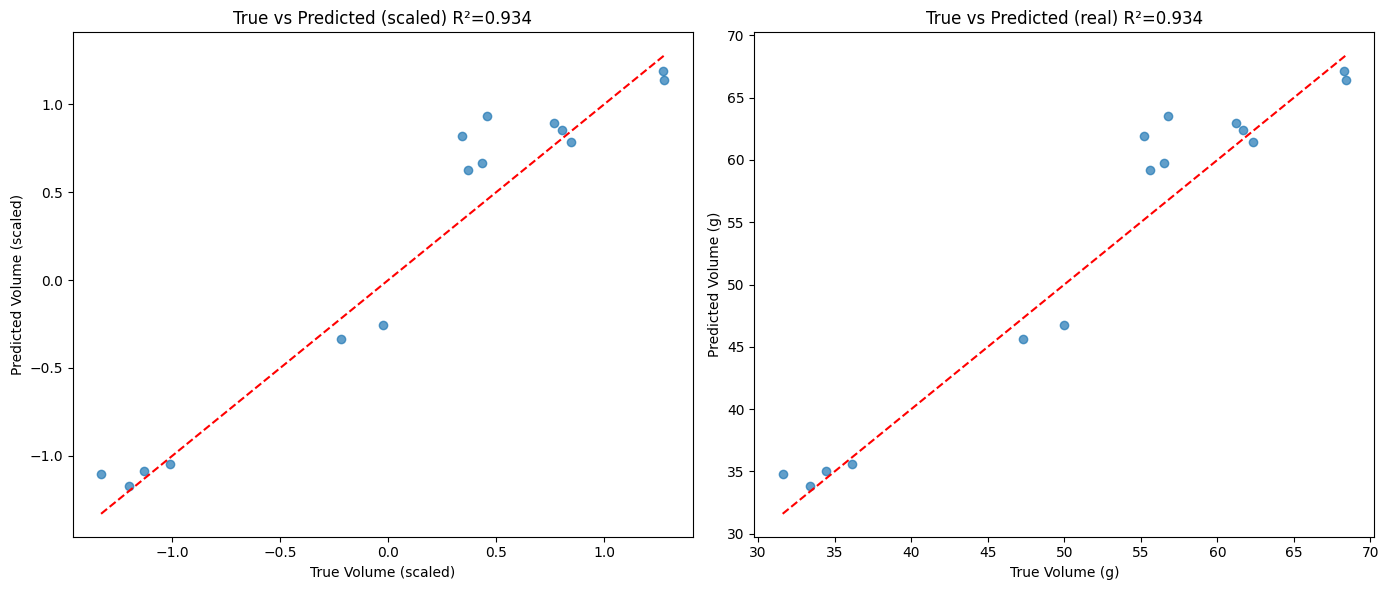

✅ Random Forest model saved at d:\Coding\Python\Project\Mongoesteen\models\rf_volume_model.pkl


In [ ]:
import os, cv2, joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D

# --- config ---
DATA_DIR =  r"d:\Coding\Python\Project\Mongoesteen\Datasets\combined2"
VOLUME_FILES_DIR = r"d:\Coding\Python\Project\Mongoesteen\Datasets\labels"
EXCEL_PATH = r"d:\Coding\Python\Project\Mongoesteen\Datasets\sheet-data.xlsx"
MODEL_SAVE_PATH = r"d:\Coding\Python\Project\Mongoesteen\models\rf_volume_model.pkl"
SCALER_PATH = r"d:\Coding\Python\Project\Mongoesteen\models\volume_scaler.save"
WEIGHT_SCALER_PATH = r"d:\Coding\Python\Project\Mongoesteen\models\weight_scaler.save"
IMG_SIZE = 224

# --- load excel weights ---
df_weights = pd.read_excel(EXCEL_PATH)
weight_dict = {}
for _, row in df_weights.iterrows():
    fname = f"combined-{int(row['Number'])}.jpg"
    weight_dict[fname] = float(row['weight g'])

# --- load data ---
def load_data(data_dir, volume_dir, weight_dict):
    image_paths, volumes, weights = [], [], []
    for filename in os.listdir(data_dir):
        if filename.lower().endswith(('.png','.jpg','.jpeg')):
            base = filename.split('.',1)[0]
            vol_file = os.path.join(volume_dir, base + ".txt")
            if os.path.exists(vol_file) and filename in weight_dict:
                try:
                    with open(vol_file,'r') as f:
                        v = float(f.read().strip())
                    image_paths.append(os.path.join(data_dir, filename))
                    volumes.append(v)
                    weights.append(weight_dict[filename])
                except:
                    pass
    return image_paths, volumes, weights

print("Loading data...")
image_paths, volumes, weights = load_data(DATA_DIR, VOLUME_FILES_DIR, weight_dict)

# --- normalize targets ---
scaler_vol = StandardScaler()
volumes_scaled = scaler_vol.fit_transform(np.array(volumes).reshape(-1,1)).flatten()
joblib.dump(scaler_vol, SCALER_PATH)

scaler_w = StandardScaler()
weights_scaled = scaler_w.fit_transform(np.array(weights).reshape(-1,1)).flatten()
joblib.dump(scaler_w, WEIGHT_SCALER_PATH)

# --- split ---
train_paths, val_paths, y_train, y_val, w_train, w_val = train_test_split(
    image_paths, volumes_scaled, weights_scaled, test_size=0.2, random_state=42
)

# --- feature extractor (Xception without top) ---
base_model = Xception(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
feature_extractor = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D()
])

def extract_features(image_paths, weights_list):
    features = []
    for p, w in zip(image_paths, weights_list):
        img = cv2.imread(p)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img.astype("float32") / 255.0
        feat = feature_extractor(np.expand_dims(img, axis=0)).numpy().flatten()
        # รวม feature + weight
        features.append(np.concatenate([feat, [w]]))
    return np.array(features)

print("Extracting features...")
X_train = extract_features(train_paths, w_train)
X_val = extract_features(val_paths, w_val)

# --- train Random Forest ---
print("Training Random Forest...")
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# --- predict ---
y_pred_scaled = rf.predict(X_val)

# --- metrics (scaled) ---
mae_scaled = mean_absolute_error(y_val, y_pred_scaled)
mse_scaled = mean_squared_error(y_val, y_pred_scaled)
r2_scaled = r2_score(y_val, y_pred_scaled)

# --- inverse transform to real ---
y_pred = scaler_vol.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()
y_true = scaler_vol.inverse_transform(np.array(y_val).reshape(-1,1)).flatten()

# --- metrics (real) ---
mae_real = mean_absolute_error(y_true, y_pred)
mse_real = mean_squared_error(y_true, y_pred)
r2_real = r2_score(y_true, y_pred)

print("=== Metrics (normalized / scaled) ===")
print(f"MAE: {mae_scaled:.6f}, MSE: {mse_scaled:.6f}, R²: {r2_scaled:.6f}")
print("=== Metrics (unscaled / real values) ===")
print(f"MAE: {mae_real:.4f}, MSE: {mse_real:.4f}, R²: {r2_real:.4f}")

# --- visualize ---
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.scatter(y_val, y_pred_scaled, alpha=0.7)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--')
plt.title(f"True vs Predicted (scaled) R²={r2_scaled:.3f}")
plt.xlabel("True Volume (scaled)")
plt.ylabel("Predicted Volume (scaled)")

plt.subplot(1,2,2)
plt.scatter(y_true, y_pred, alpha=0.7)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
plt.title(f"True vs Predicted (real) R²={r2_real:.3f}")
plt.xlabel("True Volume (g)")
plt.ylabel("Predicted Volume (g)")

plt.tight_layout()
plt.show()

# --- save model ---
joblib.dump(rf, MODEL_SAVE_PATH)
print(f"✅ Random Forest model saved at {MODEL_SAVE_PATH}")


Loading data...
Extracting features...
Training Gradient Boosting...
=== Metrics (normalized / scaled) ===
MAE: 0.131276, MSE: 0.029063, R²: 0.961185
=== Metrics (unscaled / real values) ===
MAE: 1.8526, MSE: 5.7877, R²: 0.9612


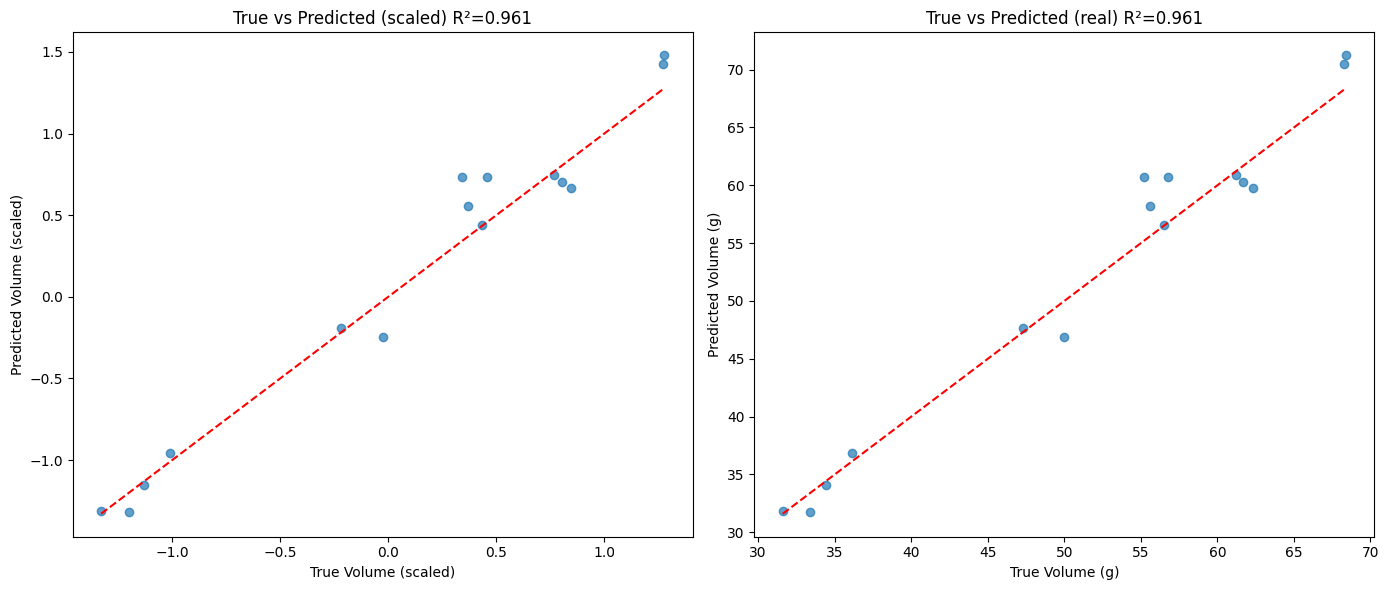

✅ Gradient Boosting model saved at d:\Coding\Python\Project\Mongoesteen\models\gb_volume_model.pkl


In [ ]:
import os, cv2, joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D

# --- config ---
DATA_DIR =  r"d:\Coding\Python\Project\Mongoesteen\Datasets\combined2"
VOLUME_FILES_DIR = r"d:\Coding\Python\Project\Mongoesteen\Datasets\labels"
EXCEL_PATH = r"d:\Coding\Python\Project\Mongoesteen\Datasets\sheet-data.xlsx"
MODEL_SAVE_PATH = r"d:\Coding\Python\Project\Mongoesteen\models\gb_volume_model.pkl"
SCALER_PATH = r"d:\Coding\Python\Project\Mongoesteen\models\volume_scaler.save"
WEIGHT_SCALER_PATH = r"d:\Coding\Python\Project\Mongoesteen\models\weight_scaler.save"
IMG_SIZE = 224

# --- load excel weights ---
df_weights = pd.read_excel(EXCEL_PATH)
weight_dict = {}
for _, row in df_weights.iterrows():
    fname = f"combined-{int(row['Number'])}.jpg"
    weight_dict[fname] = float(row['weight g'])

# --- load data ---
def load_data(data_dir, volume_dir, weight_dict):
    image_paths, volumes, weights = [], [], []
    for filename in os.listdir(data_dir):
        if filename.lower().endswith(('.png','.jpg','.jpeg')):
            base = filename.split('.',1)[0]
            vol_file = os.path.join(volume_dir, base + ".txt")
            if os.path.exists(vol_file) and filename in weight_dict:
                try:
                    with open(vol_file,'r') as f:
                        v = float(f.read().strip())
                    image_paths.append(os.path.join(data_dir, filename))
                    volumes.append(v)
                    weights.append(weight_dict[filename])
                except:
                    pass
    return image_paths, volumes, weights

print("Loading data...")
image_paths, volumes, weights = load_data(DATA_DIR, VOLUME_FILES_DIR, weight_dict)

# --- normalize targets ---
scaler_vol = StandardScaler()
volumes_scaled = scaler_vol.fit_transform(np.array(volumes).reshape(-1,1)).flatten()
joblib.dump(scaler_vol, SCALER_PATH)

scaler_w = StandardScaler()
weights_scaled = scaler_w.fit_transform(np.array(weights).reshape(-1,1)).flatten()
joblib.dump(scaler_w, WEIGHT_SCALER_PATH)

# --- split ---
train_paths, val_paths, y_train, y_val, w_train, w_val = train_test_split(
    image_paths, volumes_scaled, weights_scaled, test_size=0.2, random_state=42
)

# --- feature extractor ---
base_model = Xception(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
feature_extractor = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D()
])

def extract_features(image_paths, weights_list):
    features = []
    for p, w in zip(image_paths, weights_list):
        img = cv2.imread(p)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img.astype("float32") / 255.0
        feat = feature_extractor(np.expand_dims(img, axis=0)).numpy().flatten()
        features.append(np.concatenate([feat, [w]]))
    return np.array(features)

print("Extracting features...")
X_train = extract_features(train_paths, w_train)
X_val = extract_features(val_paths, w_val)

# --- train Gradient Boosting ---
print("Training Gradient Boosting...")
gb = GradientBoostingRegressor(
    n_estimators=500,    # จำนวนต้นไม้
    learning_rate=0.05,  # lr
    max_depth=5,         # ความลึกของต้นไม้
    random_state=42
)
gb.fit(X_train, y_train)

# --- predict ---
y_pred_scaled = gb.predict(X_val)

# --- metrics (scaled) ---
mae_scaled = mean_absolute_error(y_val, y_pred_scaled)
mse_scaled = mean_squared_error(y_val, y_pred_scaled)
r2_scaled = r2_score(y_val, y_pred_scaled)

# --- inverse transform ---
y_pred = scaler_vol.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()
y_true = scaler_vol.inverse_transform(np.array(y_val).reshape(-1,1)).flatten()

# --- metrics (real) ---
mae_real = mean_absolute_error(y_true, y_pred)
mse_real = mean_squared_error(y_true, y_pred)
r2_real = r2_score(y_true, y_pred)

print("=== Metrics (normalized / scaled) ===")
print(f"MAE: {mae_scaled:.6f}, MSE: {mse_scaled:.6f}, R²: {r2_scaled:.6f}")
print("=== Metrics (unscaled / real values) ===")
print(f"MAE: {mae_real:.4f}, MSE: {mse_real:.4f}, R²: {r2_real:.4f}")

# --- visualize ---
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.scatter(y_val, y_pred_scaled, alpha=0.7)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--')
plt.title(f"True vs Predicted (scaled) R²={r2_scaled:.3f}")
plt.xlabel("True Volume (scaled)")
plt.ylabel("Predicted Volume (scaled)")

plt.subplot(1,2,2)
plt.scatter(y_true, y_pred, alpha=0.7)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
plt.title(f"True vs Predicted (real) R²={r2_real:.3f}")
plt.xlabel("True Volume (g)")
plt.ylabel("Predicted Volume (g)")

plt.tight_layout()
plt.show()

# --- save model ---
joblib.dump(gb, MODEL_SAVE_PATH)
print(f"✅ Gradient Boosting model saved at {MODEL_SAVE_PATH}")


Loading data...
Extracting features...
Training Linear Regression...
=== Metrics (normalized / scaled) ===
MAE: 0.408100, MSE: 0.230412, R²: 0.692273
=== Metrics (unscaled / real values) ===
MAE: 5.7590, MSE: 45.8851, R²: 0.6923


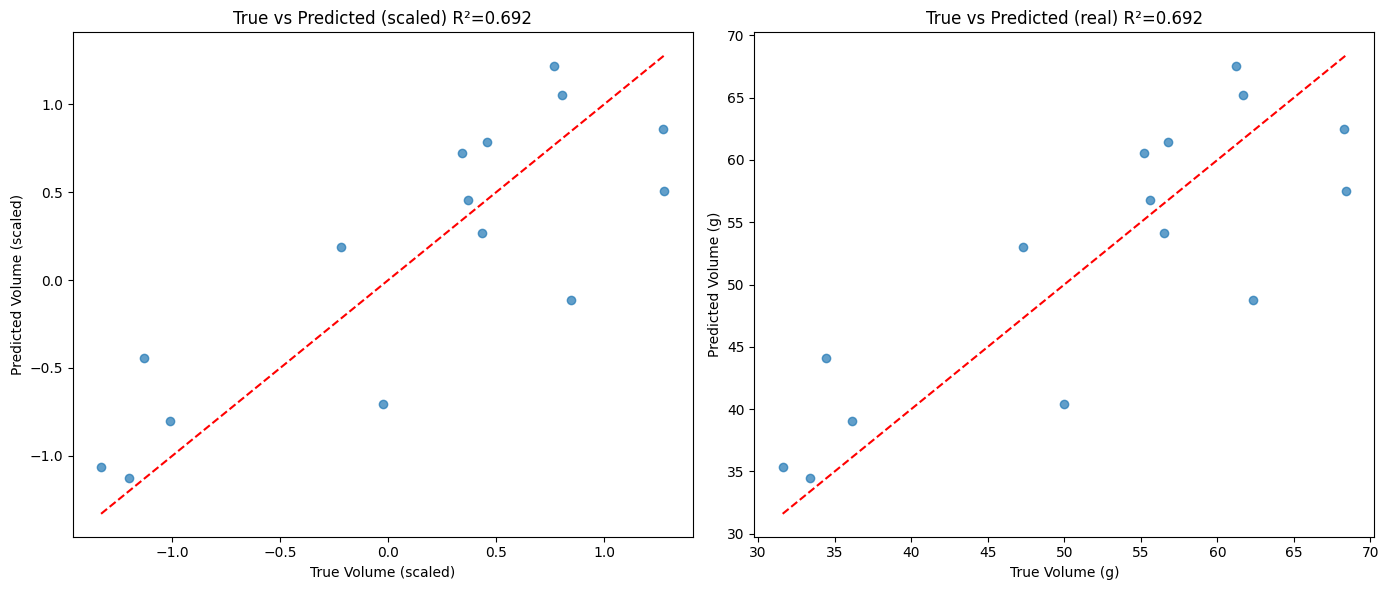

✅ Linear Regression model saved at d:\Coding\Python\Project\Mongoesteen\models\linear_volume_model.pkl


In [ ]:
import os, cv2, joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D

# --- config ---
DATA_DIR =  r"d:\Coding\Python\Project\Mongoesteen\Datasets\combined2"
VOLUME_FILES_DIR = r"d:\Coding\Python\Project\Mongoesteen\Datasets\labels"
EXCEL_PATH = r"d:\Coding\Python\Project\Mongoesteen\Datasets\sheet-data.xlsx"
MODEL_SAVE_PATH = r"d:\Coding\Python\Project\Mongoesteen\models\linear_volume_model.pkl"
SCALER_PATH = r"d:\Coding\Python\Project\Mongoesteen\models\volume_scaler.save"
WEIGHT_SCALER_PATH = r"d:\Coding\Python\Project\Mongoesteen\models\weight_scaler.save"
IMG_SIZE = 224

# --- load excel weights ---
df_weights = pd.read_excel(EXCEL_PATH)
weight_dict = {}
for _, row in df_weights.iterrows():
    fname = f"combined-{int(row['Number'])}.jpg"
    weight_dict[fname] = float(row['weight g'])

# --- load data ---
def load_data(data_dir, volume_dir, weight_dict):
    image_paths, volumes, weights = [], [], []
    for filename in os.listdir(data_dir):
        if filename.lower().endswith(('.png','.jpg','.jpeg')):
            base = filename.split('.',1)[0]
            vol_file = os.path.join(volume_dir, base + ".txt")
            if os.path.exists(vol_file) and filename in weight_dict:
                try:
                    with open(vol_file,'r') as f:
                        v = float(f.read().strip())
                    image_paths.append(os.path.join(data_dir, filename))
                    volumes.append(v)
                    weights.append(weight_dict[filename])
                except:
                    pass
    return image_paths, volumes, weights

print("Loading data...")
image_paths, volumes, weights = load_data(DATA_DIR, VOLUME_FILES_DIR, weight_dict)

# --- normalize targets ---
scaler_vol = StandardScaler()
volumes_scaled = scaler_vol.fit_transform(np.array(volumes).reshape(-1,1)).flatten()
joblib.dump(scaler_vol, SCALER_PATH)

scaler_w = StandardScaler()
weights_scaled = scaler_w.fit_transform(np.array(weights).reshape(-1,1)).flatten()
joblib.dump(scaler_w, WEIGHT_SCALER_PATH)

# --- split ---
train_paths, val_paths, y_train, y_val, w_train, w_val = train_test_split(
    image_paths, volumes_scaled, weights_scaled, test_size=0.2, random_state=42
)

# --- feature extractor ---
base_model = Xception(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
feature_extractor = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D()
])

def extract_features(image_paths, weights_list):
    features = []
    for p, w in zip(image_paths, weights_list):
        img = cv2.imread(p)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img.astype("float32") / 255.0
        feat = feature_extractor(np.expand_dims(img, axis=0)).numpy().flatten()
        features.append(np.concatenate([feat, [w]]))
    return np.array(features)

print("Extracting features...")
X_train = extract_features(train_paths, w_train)
X_val = extract_features(val_paths, w_val)

# --- train Linear Regression ---
print("Training Linear Regression...")
lr = LinearRegression()
lr.fit(X_train, y_train)

# --- predict ---
y_pred_scaled = lr.predict(X_val)

# --- metrics (scaled) ---
mae_scaled = mean_absolute_error(y_val, y_pred_scaled)
mse_scaled = mean_squared_error(y_val, y_pred_scaled)
r2_scaled = r2_score(y_val, y_pred_scaled)

# --- inverse transform ---
y_pred = scaler_vol.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()
y_true = scaler_vol.inverse_transform(np.array(y_val).reshape(-1,1)).flatten()

# --- metrics (real) ---
mae_real = mean_absolute_error(y_true, y_pred)
mse_real = mean_squared_error(y_true, y_pred)
r2_real = r2_score(y_true, y_pred)

print("=== Metrics (normalized / scaled) ===")
print(f"MAE: {mae_scaled:.6f}, MSE: {mse_scaled:.6f}, R²: {r2_scaled:.6f}")
print("=== Metrics (unscaled / real values) ===")
print(f"MAE: {mae_real:.4f}, MSE: {mse_real:.4f}, R²: {r2_real:.4f}")

# --- visualize ---
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.scatter(y_val, y_pred_scaled, alpha=0.7)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--')
plt.title(f"True vs Predicted (scaled) R²={r2_scaled:.3f}")
plt.xlabel("True Volume (scaled)")
plt.ylabel("Predicted Volume (scaled)")

plt.subplot(1,2,2)
plt.scatter(y_true, y_pred, alpha=0.7)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
plt.title(f"True vs Predicted (real) R²={r2_real:.3f}")
plt.xlabel("True Volume (g)")
plt.ylabel("Predicted Volume (g)")

plt.tight_layout()
plt.show()

# --- save model ---
joblib.dump(lr, MODEL_SAVE_PATH)
print(f"✅ Linear Regression model saved at {MODEL_SAVE_PATH}")


Loading data...
Extracting features...
Training Polynomial Linear Regression...
=== Metrics (normalized / scaled) ===
MAE: 0.442888, MSE: 0.292386, R²: 0.609503
=== Metrics (unscaled / real values) ===
MAE: 6.2500, MSE: 58.2269, R²: 0.6095


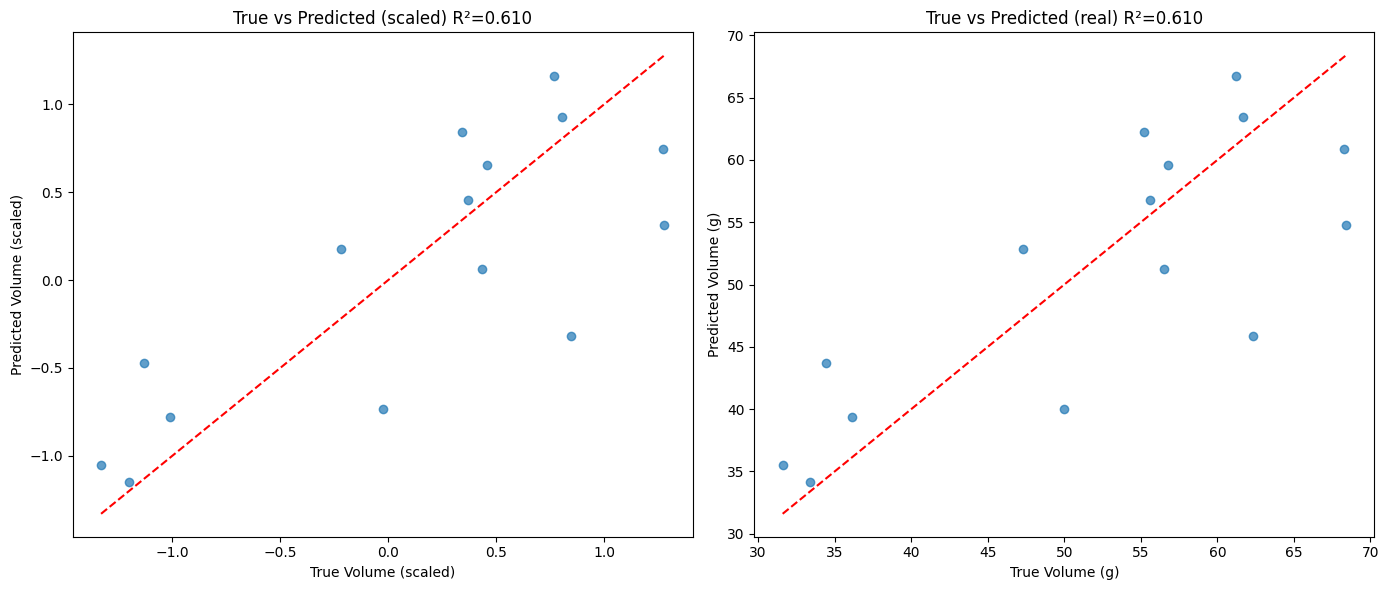

✅ Polynomial Linear Regression model saved at d:\Coding\Python\Project\Mongoesteen\models\poly_volume_model.pkl


In [ ]:
import os, cv2, joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D

# --- config ---
DATA_DIR =  r"d:\Coding\Python\Project\Mongoesteen\Datasets\combined2"
VOLUME_FILES_DIR = r"d:\Coding\Python\Project\Mongoesteen\Datasets\labels"
EXCEL_PATH = r"d:\Coding\Python\Project\Mongoesteen\Datasets\sheet-data.xlsx"
MODEL_SAVE_PATH = r"d:\Coding\Python\Project\Mongoesteen\models\poly_volume_model.pkl"
SCALER_PATH = r"d:\Coding\Python\Project\Mongoesteen\models\volume_scaler.save"
WEIGHT_SCALER_PATH = r"d:\Coding\Python\Project\Mongoesteen\models\weight_scaler.save"
IMG_SIZE = 224
POLY_DEGREE = 2  # เลือกระดับ Polynomial (2,3,...)

# --- load excel weights ---
df_weights = pd.read_excel(EXCEL_PATH)
weight_dict = {}
for _, row in df_weights.iterrows():
    fname = f"combined-{int(row['Number'])}.jpg"
    weight_dict[fname] = float(row['weight g'])

# --- load data ---
def load_data(data_dir, volume_dir, weight_dict):
    image_paths, volumes, weights = [], [], []
    for filename in os.listdir(data_dir):
        if filename.lower().endswith(('.png','.jpg','.jpeg')):
            base = filename.split('.',1)[0]
            vol_file = os.path.join(volume_dir, base + ".txt")
            if os.path.exists(vol_file) and filename in weight_dict:
                try:
                    with open(vol_file,'r') as f:
                        v = float(f.read().strip())
                    image_paths.append(os.path.join(data_dir, filename))
                    volumes.append(v)
                    weights.append(weight_dict[filename])
                except:
                    pass
    return image_paths, volumes, weights

print("Loading data...")
image_paths, volumes, weights = load_data(DATA_DIR, VOLUME_FILES_DIR, weight_dict)

# --- normalize targets ---
scaler_vol = StandardScaler()
volumes_scaled = scaler_vol.fit_transform(np.array(volumes).reshape(-1,1)).flatten()
joblib.dump(scaler_vol, SCALER_PATH)

scaler_w = StandardScaler()
weights_scaled = scaler_w.fit_transform(np.array(weights).reshape(-1,1)).flatten()
joblib.dump(scaler_w, WEIGHT_SCALER_PATH)

# --- split ---
train_paths, val_paths, y_train, y_val, w_train, w_val = train_test_split(
    image_paths, volumes_scaled, weights_scaled, test_size=0.2, random_state=42
)

# --- feature extractor (Xception without top) ---
base_model = Xception(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
feature_extractor = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D()
])

def extract_features(image_paths, weights_list):
    features = []
    for p, w in zip(image_paths, weights_list):
        img = cv2.imread(p)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img.astype("float32") / 255.0
        feat = feature_extractor(np.expand_dims(img, axis=0)).numpy().flatten()
        # รวม feature + weight
        features.append(np.concatenate([feat, [w]]))
    return np.array(features)

print("Extracting features...")
X_train = extract_features(train_paths, w_train)
X_val = extract_features(val_paths, w_val)

# --- polynomial transform ---
poly = PolynomialFeatures(degree=POLY_DEGREE)
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)

# --- train Polynomial Linear Regression ---
print("Training Polynomial Linear Regression...")
model = LinearRegression()
model.fit(X_train_poly, y_train)

# --- predict ---
y_pred_scaled = model.predict(X_val_poly)

# --- metrics (scaled) ---
mae_scaled = mean_absolute_error(y_val, y_pred_scaled)
mse_scaled = mean_squared_error(y_val, y_pred_scaled)
r2_scaled = r2_score(y_val, y_pred_scaled)

# --- inverse transform to real ---
y_pred = scaler_vol.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()
y_true = scaler_vol.inverse_transform(np.array(y_val).reshape(-1,1)).flatten()

# --- metrics (real) ---
mae_real = mean_absolute_error(y_true, y_pred)
mse_real = mean_squared_error(y_true, y_pred)
r2_real = r2_score(y_true, y_pred)

print("=== Metrics (normalized / scaled) ===")
print(f"MAE: {mae_scaled:.6f}, MSE: {mse_scaled:.6f}, R²: {r2_scaled:.6f}")
print("=== Metrics (unscaled / real values) ===")
print(f"MAE: {mae_real:.4f}, MSE: {mse_real:.4f}, R²: {r2_real:.4f}")

# --- visualize ---
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.scatter(y_val, y_pred_scaled, alpha=0.7)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--')
plt.title(f"True vs Predicted (scaled) R²={r2_scaled:.3f}")
plt.xlabel("True Volume (scaled)")
plt.ylabel("Predicted Volume (scaled)")

plt.subplot(1,2,2)
plt.scatter(y_true, y_pred, alpha=0.7)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
plt.title(f"True vs Predicted (real) R²={r2_real:.3f}")
plt.xlabel("True Volume (g)")
plt.ylabel("Predicted Volume (g)")

plt.tight_layout()
plt.show()

# --- save model ---
joblib.dump((model, poly), MODEL_SAVE_PATH)  # เก็บ model + poly transformer
print(f"✅ Polynomial Linear Regression model saved at {MODEL_SAVE_PATH}")


# Test

Loading weights from Excel...
Loading image/volume/weight pairs...
Loading scalers...
Building feature extractor and extracting validation features (this may take time)...
Loading model: Random Forest ...
Loading model: Gradient Boosting ...
Loading model: Linear Regression ...
Loading model: Polynomial Linear Regression ...

Results:
                                r2_real  mae_real   mse_real
Gradient Boosting             0.961185  1.852551   5.787730
Random Forest                 0.934262  2.418533   9.802146
Linear Regression             0.692273  5.759041  45.885066
Polynomial Linear Regression  0.609503  6.249967  58.226926
Best model by R²: Gradient Boosting (R²=0.9612)


C:\Users\ahmad\AppData\Local\Temp\ipykernel_10696\1109112712.py:181: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(residuals_df.columns, rotation=12)


Saved plot to d:\Coding\Python\Project\Mongoesteen\results\validation_plots_best_model.png


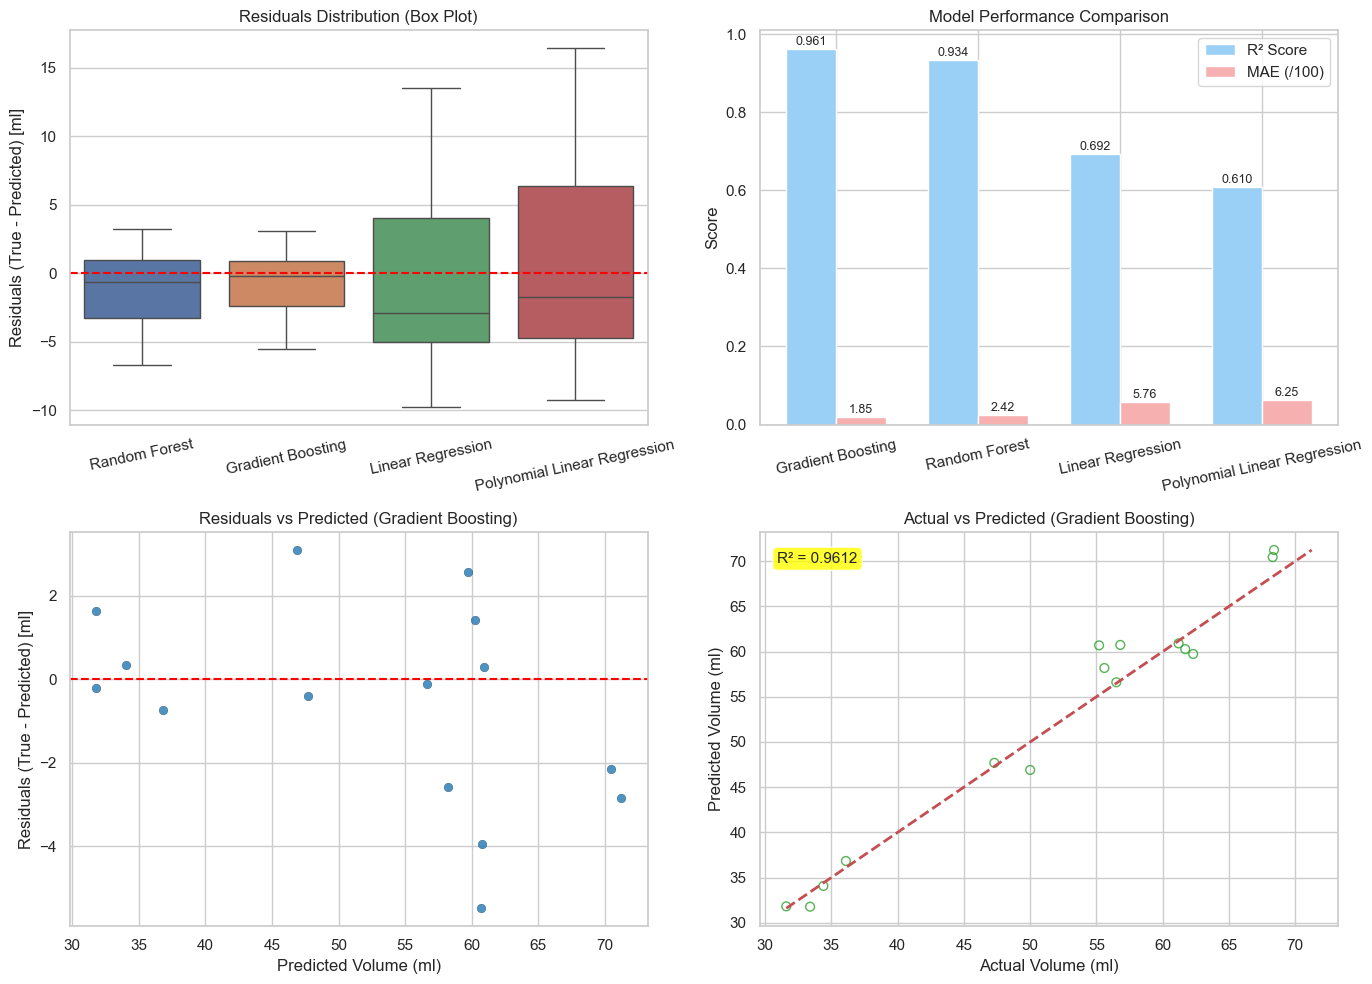

In [16]:
import os, cv2, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D

# ==========================
# CONFIG - แก้พาธให้ตรงกับระบบคุณ
# ==========================
DATA_DIR =  r"d:\Coding\Python\Project\Mongoesteen\Datasets\combined2"
VOLUME_FILES_DIR = r"d:\Coding\Python\Project\Mongoesteen\Datasets\labels"
EXCEL_PATH = r"d:\Coding\Python\Project\Mongoesteen\Datasets\sheet-data.xlsx"

MODEL_PATHS = {
    "Random Forest": r"d:\Coding\Python\Project\Mongoesteen\models\rf_volume_model.pkl",
    "Gradient Boosting": r"d:\Coding\Python\Project\Mongoesteen\models\gb_volume_model.pkl",
    "Linear Regression": r"d:\Coding\Python\Project\Mongoesteen\models\linear_volume_model.pkl",
    "Polynomial Linear Regression": r"d:\Coding\Python\Project\Mongoesteen\models\poly_volume_model.pkl",
}

SCALER_VOL_PATH = r"d:\Coding\Python\Project\Mongoesteen\models\volume_scaler.save"  # volume scaler
SCALER_W_PATH = r"d:\Coding\Python\Project\Mongoesteen\models\weight_scaler.save"   # weight scaler

IMG_SIZE = 224
TEST_SIZE = 0.2
RANDOM_STATE = 42

# บันทึกผลไปที่โฟลเดอร์ results ในโปรเจกต์ (แก้ตามต้องการ)
OUT_PNG_DIR = r"d:\Coding\Python\Project\Mongoesteen\results"
OUT_PNG = os.path.join(OUT_PNG_DIR, "validation_plots_best_model.png")

# ==========================
# helper functions
# ==========================
def build_feature_extractor(img_size=IMG_SIZE):
    base = Xception(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))
    return tf.keras.Sequential([base, GlobalAveragePooling2D()])

def load_weights_from_excel(excel_path):
    df = pd.read_excel(excel_path)
    weight_dict = {}
    for _, row in df.iterrows():
        try:
            fname = f"combined-{int(row['Number'])}.jpg"
            weight_dict[fname] = float(row['weight g'])
        except Exception:
            pass
    return weight_dict

def load_image_volume_weight_pairs(data_dir, volume_dir, weight_dict):
    image_paths, volumes, weights = [], [], []
    for filename in sorted(os.listdir(data_dir)):
        if not filename.lower().endswith(('.png','.jpg','.jpeg')):
            continue
        base = filename.split('.',1)[0]
        vol_file = os.path.join(volume_dir, base + ".txt")
        if os.path.exists(vol_file) and filename in weight_dict:
            try:
                with open(vol_file, 'r') as f:
                    v = float(f.read().strip())
                image_paths.append(os.path.join(data_dir, filename))
                volumes.append(v)
                weights.append(weight_dict[filename])
            except Exception:
                pass
    return image_paths, np.array(volumes, dtype=float), np.array(weights, dtype=float)

def extract_features(feature_extractor, image_paths, weights_scaled):
    feats = []
    for p, w in zip(image_paths, weights_scaled):
        img = cv2.imread(p)
        if img is None:
            img = np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img.astype("float32") / 255.0
        f = feature_extractor(np.expand_dims(img, axis=0)).numpy().flatten()
        feats.append(np.concatenate([f, [w]]))
    return np.array(feats)

# ==========================
# Load data & scalers
# ==========================
print("Loading weights from Excel...")
weight_dict = load_weights_from_excel(EXCEL_PATH)

print("Loading image/volume/weight pairs...")
image_paths, volumes_raw, weights_raw = load_image_volume_weight_pairs(DATA_DIR, VOLUME_FILES_DIR, weight_dict)
if len(image_paths) == 0:
    raise SystemExit("No image/label pairs found. ตรวจสอบ DATA_DIR, VOLUME_FILES_DIR และไฟล์ Excel")

print("Loading scalers...")
scaler_vol = joblib.load(SCALER_VOL_PATH)
scaler_w = joblib.load(SCALER_W_PATH)

volumes_scaled = scaler_vol.transform(volumes_raw.reshape(-1,1)).flatten()
weights_scaled = scaler_w.transform(weights_raw.reshape(-1,1)).flatten()

# split (ใช้ same random_state กับตอน train ถ้าต้องการ replicate)
train_paths, val_paths, y_train_scaled, y_val_scaled, w_train_scaled, w_val_scaled = train_test_split(
    image_paths, volumes_scaled, weights_scaled, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# ==========================
# extract features for validation set
# ==========================
print("Building feature extractor and extracting validation features (this may take time)...")
feature_extractor = build_feature_extractor(IMG_SIZE)
X_val = extract_features(feature_extractor, val_paths, w_val_scaled)

# ==========================
# evaluate models
# ==========================
results = {}
residuals = {}
preds_store = {}

for model_name, model_path in MODEL_PATHS.items():
    if not os.path.exists(model_path):
        print(f"[skip] Model not found: {model_name}")
        continue
    print(f"Loading model: {model_name} ...")
    loaded = joblib.load(model_path)

    # if Polynomial saved as (model, poly)
    if isinstance(loaded, (list, tuple)) and len(loaded) >= 2:
        model, poly = loaded[0], loaded[1]
        X_val_trans = poly.transform(X_val)
        y_pred_scaled = model.predict(X_val_trans)
    else:
        model = loaded
        y_pred_scaled = model.predict(X_val)

    y_pred_real = scaler_vol.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()
    y_true_real = scaler_vol.inverse_transform(y_val_scaled.reshape(-1,1)).flatten()

    mae_s = mean_absolute_error(y_val_scaled, y_pred_scaled)
    mse_s = mean_squared_error(y_val_scaled, y_pred_scaled)
    r2_s = r2_score(y_val_scaled, y_pred_scaled)

    mae_r = mean_absolute_error(y_true_real, y_pred_real)
    mse_r = mean_squared_error(y_true_real, y_pred_real)
    r2_r = r2_score(y_true_real, y_pred_real)

    results[model_name] = {"r2_real": r2_r, "mae_real": mae_r, "mse_real": mse_r}
    residuals[model_name] = (y_true_real - y_pred_real)
    preds_store[model_name] = {"y_true": y_true_real, "y_pred": y_pred_real}

# Convert results table
df_res = pd.DataFrame(results).T.sort_values("r2_real", ascending=False)
print("\nResults:\n", df_res)

# ==========================
# Find best model by r2_real
# ==========================
if len(df_res) == 0:
    raise SystemExit("No models evaluated.")
best_model = df_res.index[0]  # highest R² because sorted descending
print(f"Best model by R²: {best_model} (R²={df_res.loc[best_model,'r2_real']:.4f})")

# ==========================
# Plotting - 2x2 figure like your example
# ==========================
sns.set(style="whitegrid")
fig, axes = plt.subplots(2,2, figsize=(14,10))
ax1, ax2, ax3, ax4 = axes.flatten()

# 1) Residuals Distribution (boxplot)
residuals_df = pd.DataFrame(residuals)
sns.boxplot(data=residuals_df, ax=ax1)
ax1.axhline(0, color='red', linestyle='--')
ax1.set_title("Residuals Distribution (Box Plot)")
ax1.set_ylabel("Residuals (True - Predicted) [ml]")
ax1.set_xticklabels(residuals_df.columns, rotation=12)

# 2) Model Performance Comparison (R2 & MAE)
model_names = df_res.index.tolist()
r2_vals = df_res["r2_real"].values
mae_vals = df_res["mae_real"].values

x = np.arange(len(model_names))
width = 0.35
bars1 = ax2.bar(x - width/2, r2_vals, width, label='R² Score', color='#9ad0f5')
bars2 = ax2.bar(x + width/2, mae_vals/100.0, width, label='MAE (/100)', color='#f6b0b0')
ax2.set_xticks(x)
ax2.set_xticklabels(model_names, rotation=12)
ax2.set_ylabel("Score")
ax2.set_title("Model Performance Comparison")
for i, v in enumerate(r2_vals):
    ax2.text(i - width/2, v + 0.01, f"{v:.3f}", ha='center', fontsize=9)
for i, v in enumerate(mae_vals):
    ax2.text(i + width/2, v/100.0 + 0.01, f"{v:.2f}", ha='center', fontsize=9)
ax2.legend()

# Bottom plots: use best_model
y_true = preds_store[best_model]["y_true"]
y_pred = preds_store[best_model]["y_pred"]
resid_best = y_true - y_pred

# 3) Residuals vs Predicted (best model)
ax3.scatter(y_pred, resid_best, alpha=0.8, s=40, color='tab:blue', edgecolor='k', linewidth=0.2)
ax3.axhline(0, color='red', linestyle='--')
ax3.set_xlabel("Predicted Volume (ml)")
ax3.set_ylabel("Residuals (True - Predicted) [ml]")
ax3.set_title(f"Residuals vs Predicted ({best_model})")

# 4) Actual vs Predicted (best model) with R² box
ax4.scatter(y_true, y_pred, alpha=0.8, s=40, facecolors='none', edgecolors='tab:green')
mn, mx = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
ax4.plot([mn, mx], [mn, mx], 'r--', linewidth=2)
ax4.set_xlabel("Actual Volume (ml)")
ax4.set_ylabel("Predicted Volume (ml)")
ax4.set_title(f"Actual vs Predicted ({best_model})")
r2_best = df_res.loc[best_model,'r2_real']
ax4.text(0.03, 0.95, f"R² = {r2_best:.4f}", transform=ax4.transAxes,
         fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))

plt.tight_layout()

# === create output dir if not exists, then save ===
try:
    os.makedirs(OUT_PNG_DIR, exist_ok=True)
    plt.savefig(OUT_PNG, dpi=200)
    print(f"Saved plot to {OUT_PNG}")
except Exception as e:
    print(f"[warning] Failed to save to {OUT_PNG}: {e}")
    # fallback: save to current working directory
    fallback = "validation_plots_best_model.png"
    plt.savefig(fallback, dpi=200)
    print(f"Saved to fallback: {os.path.abspath(fallback)}")

plt.show()
